In [164]:

import yfinance as yf
import pandas as pd
from math import sqrt
from scipy.stats import t 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import requests
from termcolor import colored as cl
from math import floor


In [165]:
nasdaq = yf.download("^IXIC", start="2010-01-01", end="2023-05-01")
nsei = yf.download("^NSEI", start="2010-01-01", end="2023-05-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [166]:
nsei

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0
...,...,...,...,...,...,...
2023-04-24,17707.550781,17754.500000,17612.500000,17743.400391,17743.400391,255700
2023-04-25,17761.550781,17807.449219,17716.849609,17769.250000,17769.250000,297400
2023-04-26,17767.300781,17827.750000,17711.199219,17813.599609,17813.599609,233000


In [167]:
def daily_returns(df):
    df['Daily_Returns']=(df['Close']-df['Open'])*100/df['Open']

In [168]:
daily_returns(nasdaq)
daily_returns(nsei)

In [169]:
df1 = pd.DataFrame(nsei.Close)
df2 = pd.DataFrame(nasdaq.Close)

In [170]:
df1.shape, df2.shape

((3268, 1), (3353, 1))

Common trading days for finding correlation:

In [171]:
common_trading_days = nasdaq.index.intersection(nsei.index)

df3 = nasdaq.Close.loc[common_trading_days]
df4 = nsei.Close.loc[common_trading_days]

In [172]:
df3.shape, df4.shape

((3182,), (3182,))

In [173]:
correlation_coefficient = df3.corr(df4, method = 'pearson')
correlation_coefficient

0.9513138758576785

In [174]:

n = len(df3)
degrees_of_freedom = n - 2


t_value = correlation_coefficient * np.sqrt((n - 2) / (1 - correlation_coefficient**2))
#helps assess the statistical significance of the correlation and provides evidence for or against the presence of a true correlation between the variables.
p_value = 2 * (1 - t.cdf(abs(t_value), df=degrees_of_freedom))
#p-value < 0.05 that means that the correlation is statistically significant. The p-value represents the probability of observing a correlation coefficient

print("Correlation Coefficient:", correlation_coefficient)
print("t_value:", t_value)
print("p_value:", p_value)

Correlation Coefficient: 0.9513138758576785
t_value: 174.04887637539352
p_value: 0.0


In [175]:
coeff_determination = correlation_coefficient**2 
# Square the correlation coefficient (r) to obtain the coefficient of determination (r-squared). It represents the proportion of the variance in one variable that can be explained by the other variable. A higher r-squared value indicates a stronger relationship.
coeff_determination

0.9049980903993584

In [176]:
correlation_coefficient 

0.9513138758576785

Since By defination a higher correlation indicates a stronger relationship between the variables and -1<=correlation<=1 More the correlation in close to 1 more the factors are correlated and have a strong direct relationship and also as mentioned in comments p_value (calculated using t_value)if low implies correlation is significant and thus we conclude the mentioned

Task 2: Lead-Lag Relationship




[]

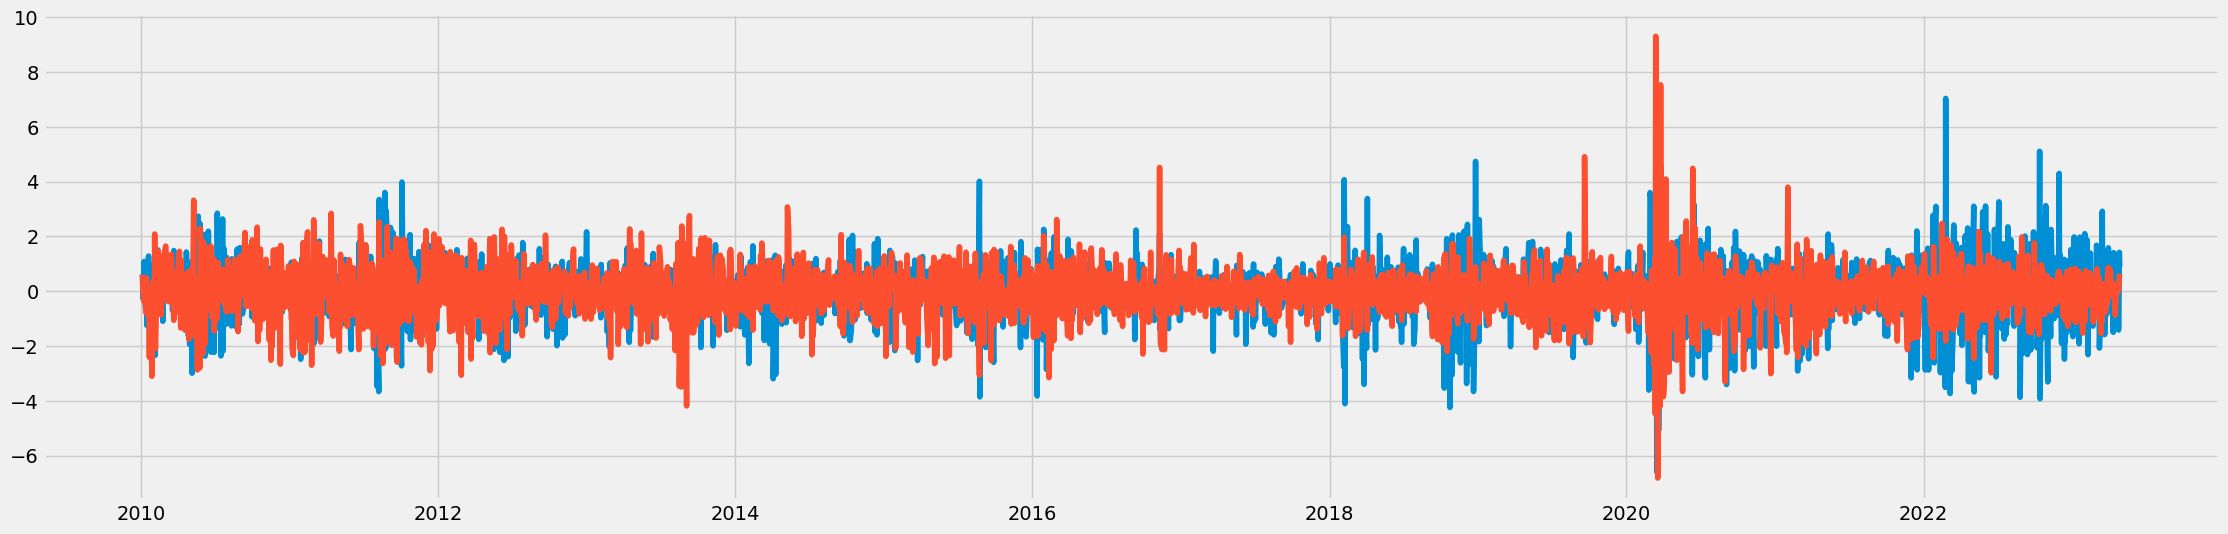

In [177]:
nasd_ret = nasdaq.Daily_Returns.loc[common_trading_days]
nse_ret = nsei.Daily_Returns.loc[common_trading_days]
plt.figure(figsize=(25,6))
plt.plot(nasd_ret)
plt.plot(nse_ret)
plt.plot()

In [178]:
# df3->nasdaq
# df4->nsei
crosscorr_values = [df3.corr(df4.shift(lag)) for lag in range(-20,20)]#range as specified on channel

In [179]:
max_lag=max(crosscorr_values)
min_lag=min(crosscorr_values)
print("max_lag:",max_lag)
print("min_lag:",min_lag)

max_lag: 0.952588022856614
min_lag: 0.9414671972645148


Highest lagged cross-correlation at lag = 20 means that nsei leads nasdaq by 20 lags. 

Patterns of Leading or Lagging Behavior:

* If the correlation coefficient is positive and the lagged cross-correlation at a positive lag is high, it indicates that one index tends to lead the other with a delay of that specific lag.
* If the correlation coefficient is negative and the lagged cross-correlation at a negative lag is high, it suggests that one index tends to lag behind the other with a delay of that specific lag.
* Analyzing the strength and consistency of the lagged cross-correlation at different lags can help identify the dominant leading or lagging behavior between the two indices.

* The leading index is the one that consistently precedes or provides early signals for price movements. --> NSEI
* The lagging index is the one that tends to follow or react to the movements of the leading index. --> NASDAQ

The index chosen for parameter optimization should be the leading index. This is because the leading index provides **early signals** or indications of potential price movements, allowing for better parameter optimization. By optimizing the parameters on the leading index, we can potentially generate more accurate trading signals for the lagging index. 

In [180]:
plt.rcParams['figure.figsize'] = (25,20)
plt.style.use('fivethirtyeight')

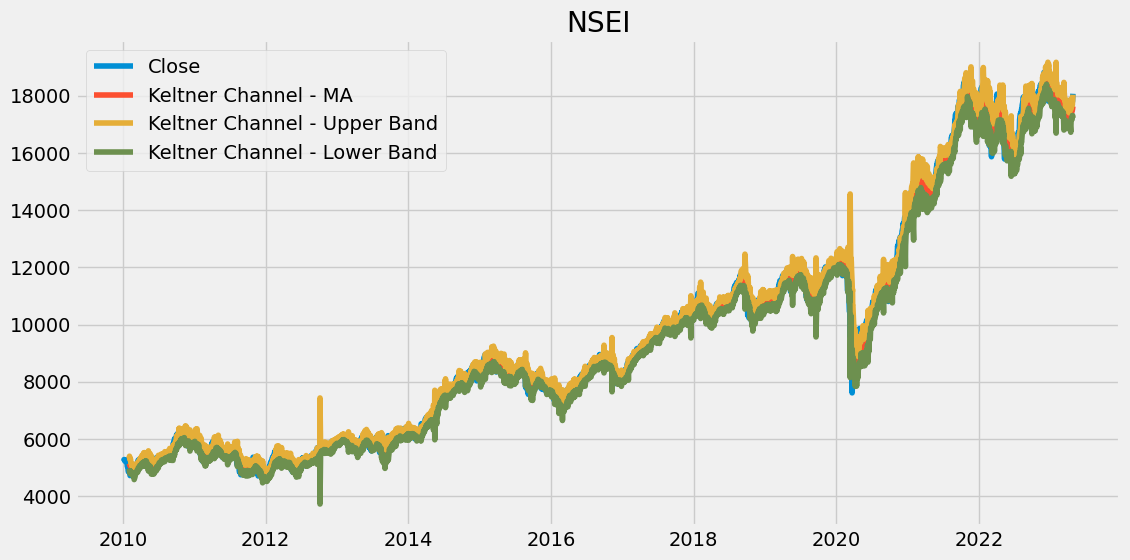

In [181]:
data=nsei
data['KC_MA'] = data['Close'].rolling(window=20).mean()
data['KC_ATR'] = data['High'] - data['Low']
data['KC_UB'] = data['KC_MA'] + (2 * data['KC_ATR'])
data['KC_LB'] = data['KC_MA'] - (2 * data['KC_ATR'])
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close')
plt.plot(data['KC_MA'], label='Keltner Channel - MA')
plt.plot(data['KC_UB'], label='Keltner Channel - Upper Band')
plt.plot(data['KC_LB'], label='Keltner Channel - Lower Band')
plt.title("NSEI")
plt.legend()
plt.show()

In [182]:
import numpy as np
def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)-1):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

In [183]:
buy_price, sell_price, kc_signal = implement_kc_strategy(data['Close'], data['KC_UB'], data['KC_LB'])
data=data.iloc[:-1,:]

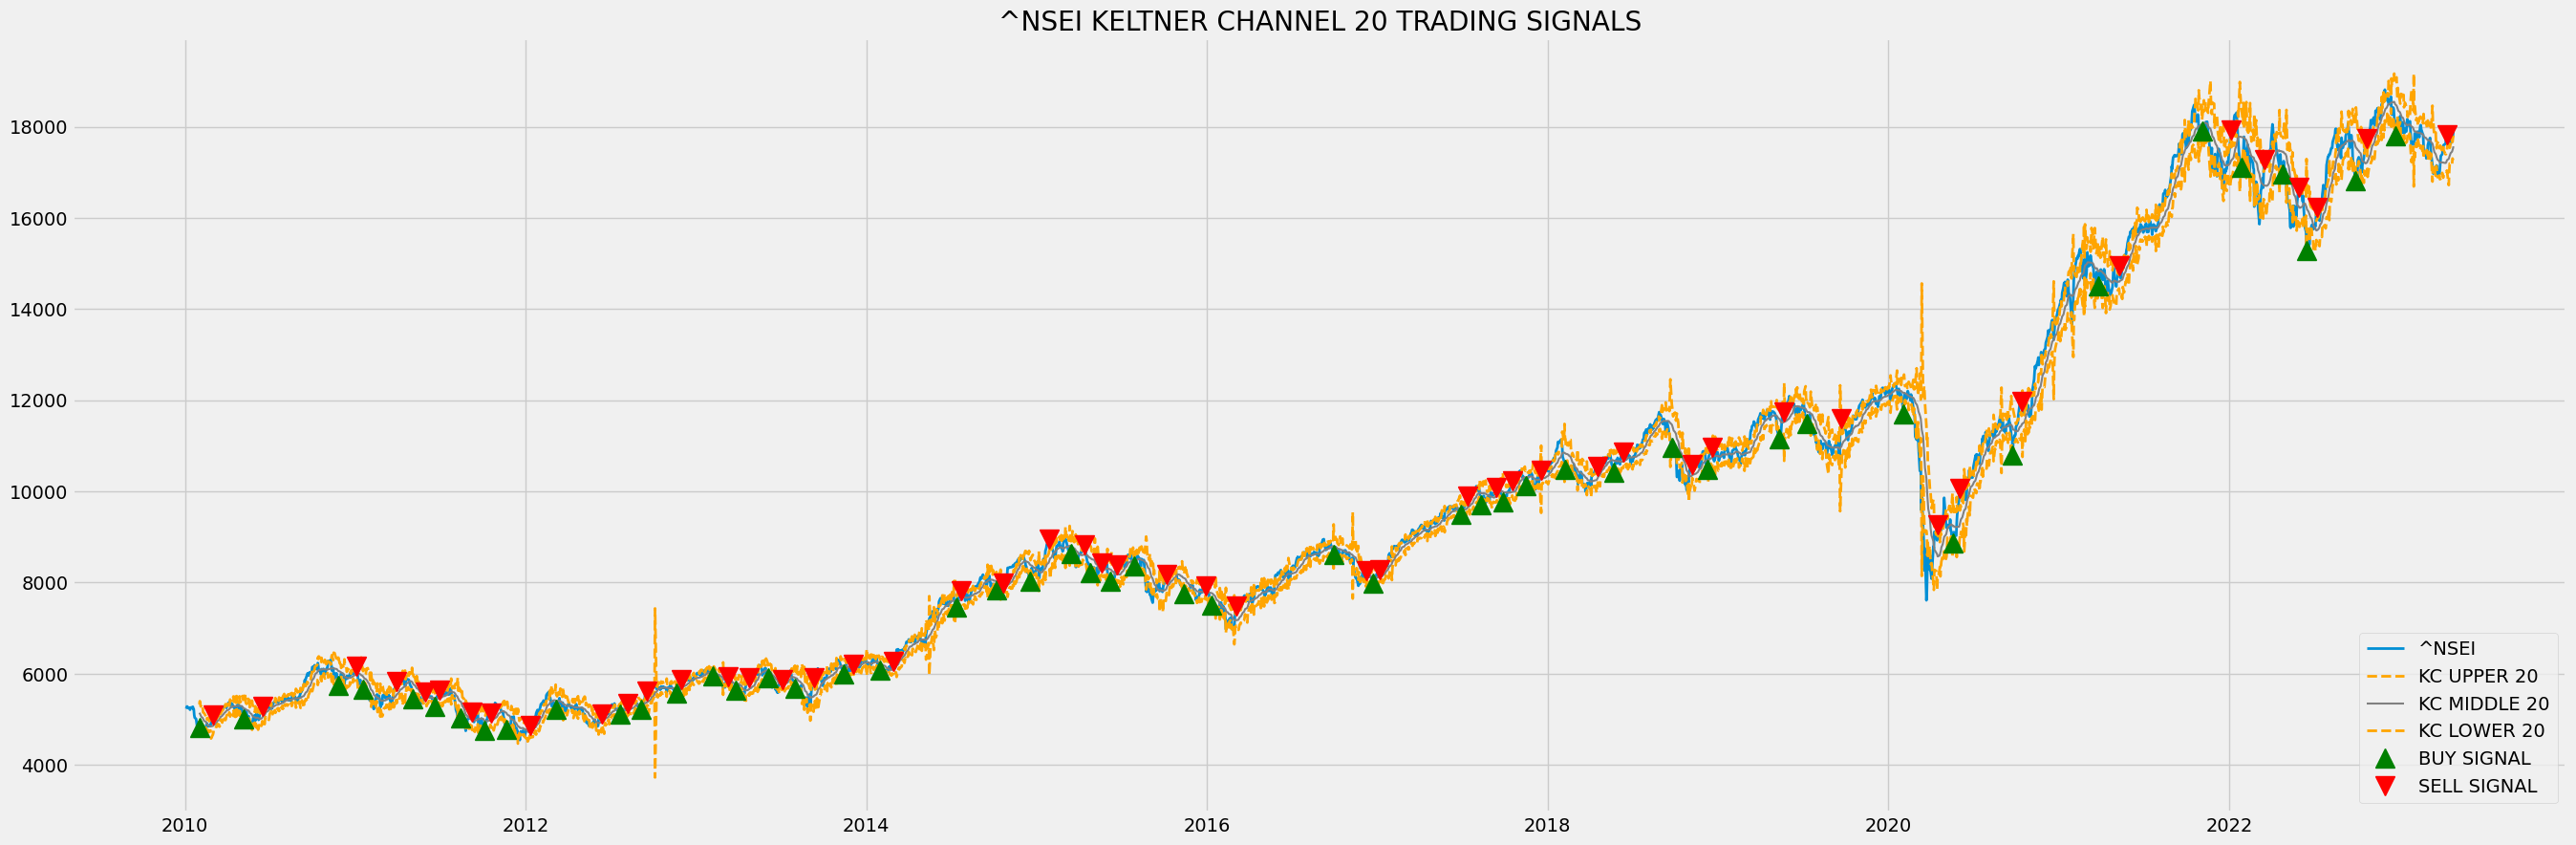

In [184]:
plt.figure(figsize=(30,10))
plt.plot(data['Close'], linewidth = 2, label = '^NSEI')
plt.plot(data['KC_UB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(data['KC_MA'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(data['KC_LB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
plt.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('^NSEI KELTNER CHANNEL 20 TRADING SIGNALS')
plt.show()

In [185]:
buy_kc=pd.DataFrame(buy_price)
buy_kc=buy_kc.fillna(0)
buy_kc=buy_kc[~(buy_kc == 0).all(axis=1)]
sell_kc=pd.DataFrame(sell_price)
sell_kc=sell_kc.fillna(0)
sell_kc=sell_kc[~(sell_kc == 0).all(axis=1)]

In [186]:
np1=np.array(buy_kc)
np2=np.array(sell_kc)
(np2-np1).mean(), (np2-np1).std()

(219.43201171875, 500.91326541016883)

In [187]:
buy_kelt=pd.DataFrame(buy_price)
sell_kelt=pd.DataFrame(sell_price)
buy_kelt=buy_kelt.fillna('ffill')
sell_kelt=sell_kelt.fillna('ffill')

Judging the performance

In [188]:
def sharpe_ratio(data, risk_free_rate=0):
    # Calculate Average  Return
    mean_daily_return = data.mean()
    # Calculate Standard Deviation
    sigma = data.std()
    return (mean_daily_return/sigma)

In [189]:
def sortino_ratio(data):
    mean_return = data.mean()
    std_neg = data[data<0].std()
    return mean_return/std_neg


In [190]:
print("Sharpe Ratio", sharpe_ratio(np2-np1))
print("Sortino Ratio", sortino_ratio(np2-np1))
print("MDD_KC",(np1-np2).min()/np2[18,0]*100,"%")
print("CUMM_Return_KC",((np2-np1)/np1).max()*100,"%")

Sharpe Ratio 0.43806388624799114
Sortino Ratio 0.30309615580830157
MDD_KC -18.837973195892648 %
CUMM_Return_KC 13.317230883005408 %


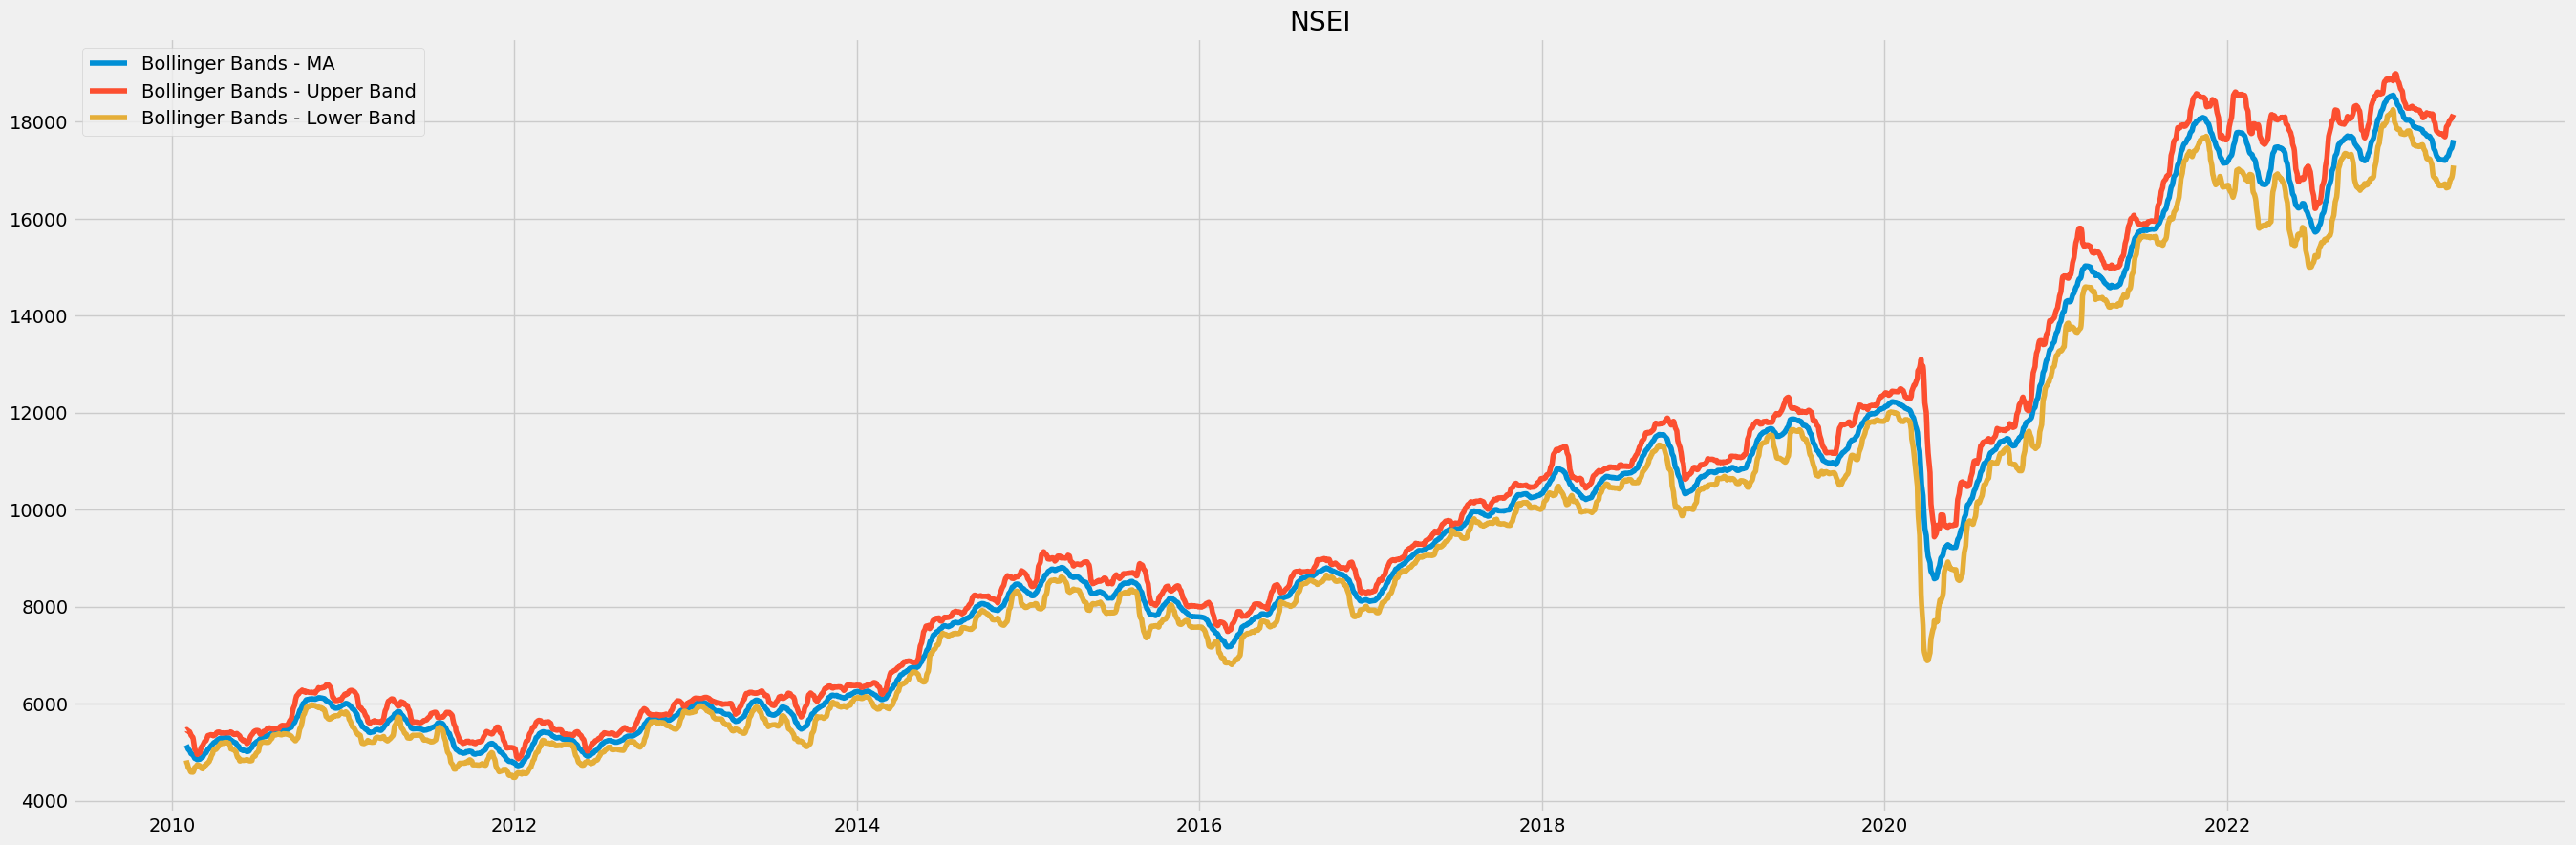

In [191]:
data=nsei
data['BB_MA'] = data['Close'].rolling(window=20).mean()
data['BB_std'] = data['Close'].rolling(window=20).std()
data['BB_UB'] = data['BB_MA'] + (2 * data['BB_std'])
data['BB_LB'] = data['BB_MA'] - (2 * data['BB_std'])
plt.figure(figsize=(30, 10))
plt.plot(data['BB_MA'], label='Bollinger Bands - MA')
plt.plot(data['BB_UB'], label='Bollinger Bands - Upper Band')
plt.plot(data['BB_LB'], label='Bollinger Bands - Lower Band')
plt.legend(loc='best')
plt.title("NSEI")
plt.show()

In [192]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price_bb = []
    sell_price_bb = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price_bb.append(data[i])
                sell_price_bb.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price_bb.append(np.nan)
                sell_price_bb.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price_bb.append(np.nan)
            sell_price_bb.append(np.nan)
            bb_signal.append(0)
            
    return buy_price_bb, sell_price_bb, bb_signal

In [193]:
buy_price_bb, sell_price_bb, bb_signal = implement_bb_strategy(data['Close'], data['BB_UB'], data['BB_LB'])

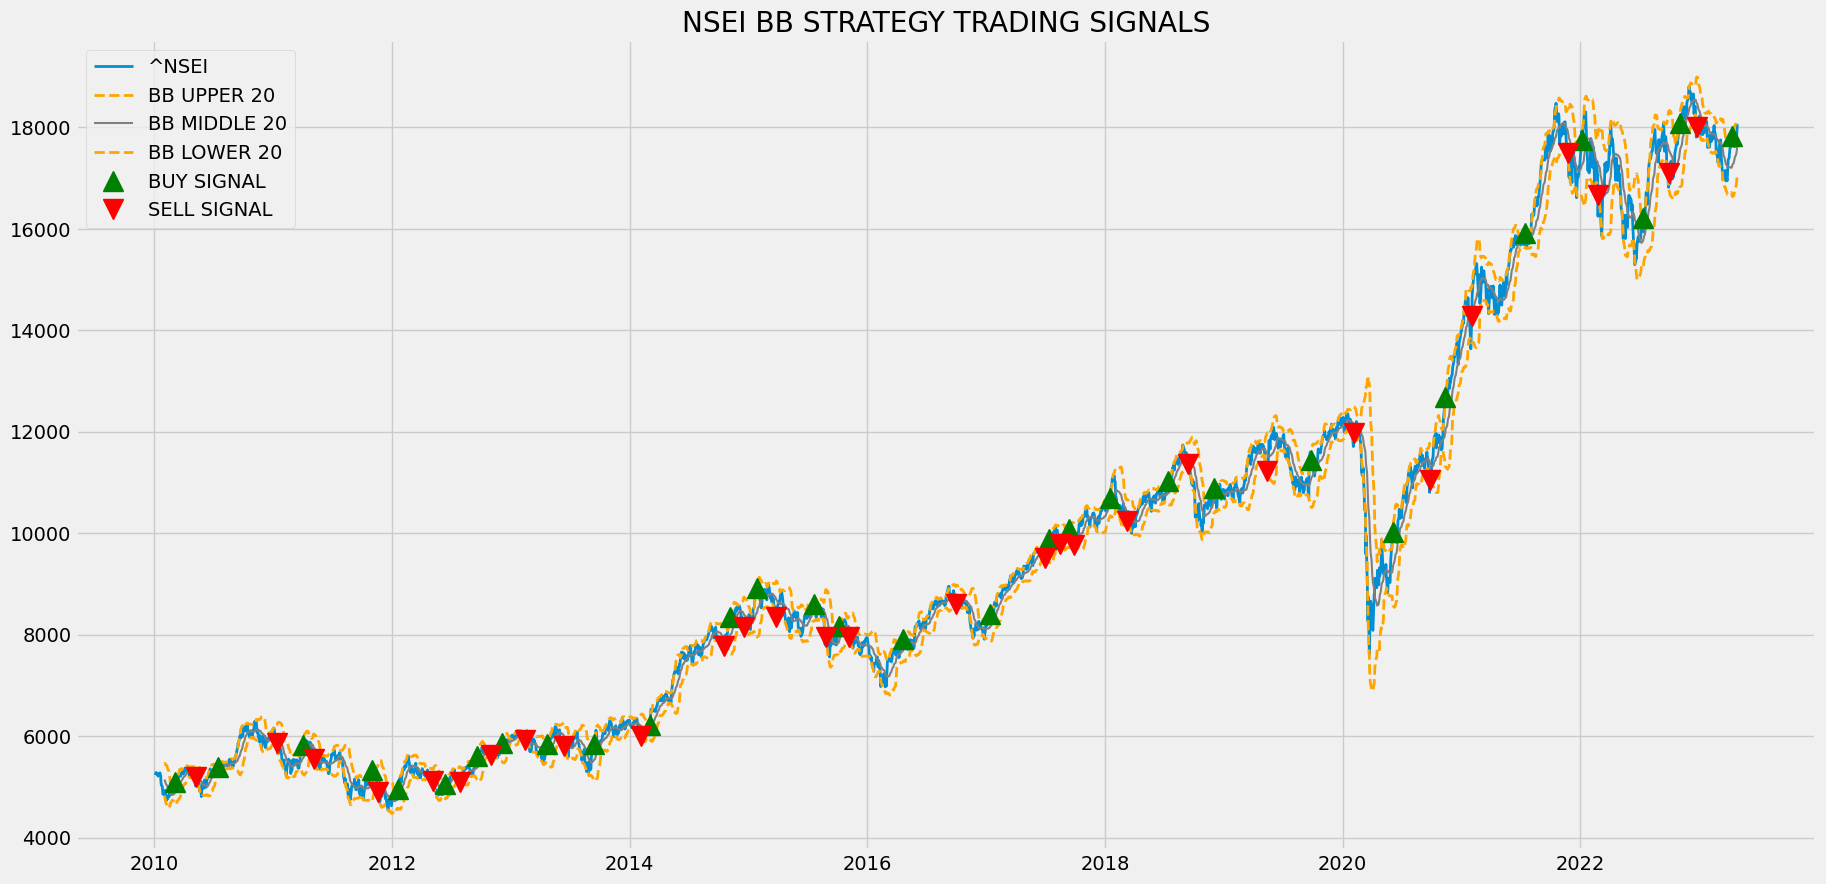

In [194]:
plt.figure(figsize=(20,10))
plt.plot(data['Close'], linewidth = 2, label = '^NSEI')
plt.plot(data['BB_UB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'BB UPPER 20')
plt.plot(data['BB_MA'], linewidth = 1.5, color = 'grey', label = 'BB MIDDLE 20')
plt.plot(data['BB_LB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'BB LOWER 20')
plt.plot(data.index, buy_price_bb, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price_bb, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('NSEI BB STRATEGY TRADING SIGNALS')
plt.show()

In [195]:
buy_price_bb=pd.DataFrame(buy_price_bb)
buy_price_bb=buy_price_bb.fillna(0)
buy_price_bb=buy_price_bb[~(buy_price_bb == 0).all(axis=1)]
sell_price_bb=pd.DataFrame(sell_price_bb)
sell_price_bb=sell_price_bb.fillna(0)
sell_price_bb=sell_price_bb[~(sell_price_bb == 0).all(axis=1)]
np_buy_bb=np.array(buy_price_bb)
np_buy_bb = np_buy_bb[:-1]
np_sell_bb=np.array(sell_price_bb)
(np_sell_bb-np_buy_bb).mean() , (np_sell_bb-np_buy_bb).std()

(216.96383351293105, 669.5380314208738)

In [196]:
def sharpe_ratio(data, risk_free_rate=0.03):
    # Calculate Average  Return
    mean_return = data.mean()
    # Calculate Standard Deviation
    sigma = data.std()
    return (mean_return/sigma)

def sortino_ratio(data):
    # Calculate Average  Return
    mean_return = data.mean()
    # Calculate Standard Deviation
    std_neg = data[data<0].std()
    return mean_return/std_neg

In [197]:
print("Sharpe Ratio", sharpe_ratio(np_sell_bb-np_buy_bb))
print("Sortino Ratio" , sortino_ratio(np_sell_bb-np_buy_bb))
print("MDD_BB",(np_buy_bb-np_sell_bb).min()/np_sell_bb[6,0]*100,"%")
print("CUMM_Return_BB",((np_sell_bb-np_buy_bb)/np_buy_bb).max()*100,"%")

Sharpe Ratio 0.3240500514250054
Sortino Ratio 0.7512898905355797
MDD_BB -28.300449051562993 %
CUMM_Return_BB 25.046411223769834 %


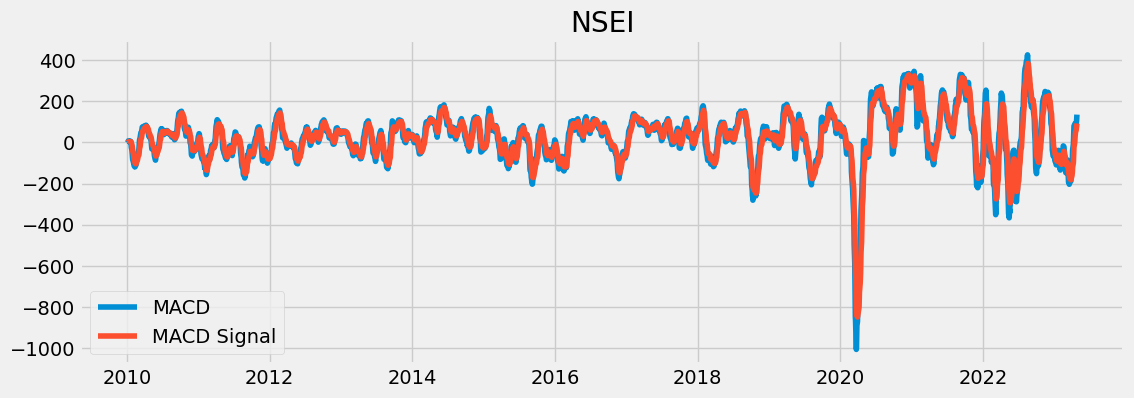

In [198]:
data=nsei
data['MACD_12EMA'] = data['Close'].ewm(span=12, adjust=False).mean()
data['MACD_26EMA'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['MACD_12EMA'] - data['MACD_26EMA']
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
plt.figure(figsize=(12, 4))
plt.plot(data['MACD'], label='MACD')
plt.plot(data['MACD_Signal'], label='MACD Signal')
plt.legend()
plt.title("NSEI")
plt.show()

In [199]:
def generate_signals(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(0,len(df)):
        if df['MACD'][i] > df['MACD_Signal'][i]:         
            sell_list.append(np.nan)                 
            if flag != 1:                            
                buy_list.append(df['Close'][i])     
                flag = 1
            else:
                buy_list.append(np.nan)
        elif df['MACD'][i] < df['MACD_Signal'][i]:
            buy_list.append(np.nan)
            if flag != 0:
                sell_list.append(df['Close'][i])
                flag = 0
            else:
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            


# create buy and sell column
signal = generate_signals(data)
data['buy_sig'] = signal[0]
data['sell_sig'] = signal[1]

In [200]:
buy_sig_md=pd.DataFrame(data['buy_sig']).fillna(0)
buy_sig_md

buy_sig_md=buy_sig_md[~(buy_sig_md == 0).all(axis=1)]
buy_sig_md
np_buy_md=np.array(buy_sig_md)

sell_sig_md=pd.DataFrame(data['sell_sig']).fillna(0)
sell_sig_md

sell_sig_md=sell_sig_md[~(sell_sig_md == 0).all(axis=1)]
sell_sig_md
np_sell_md=np.array(sell_sig_md)

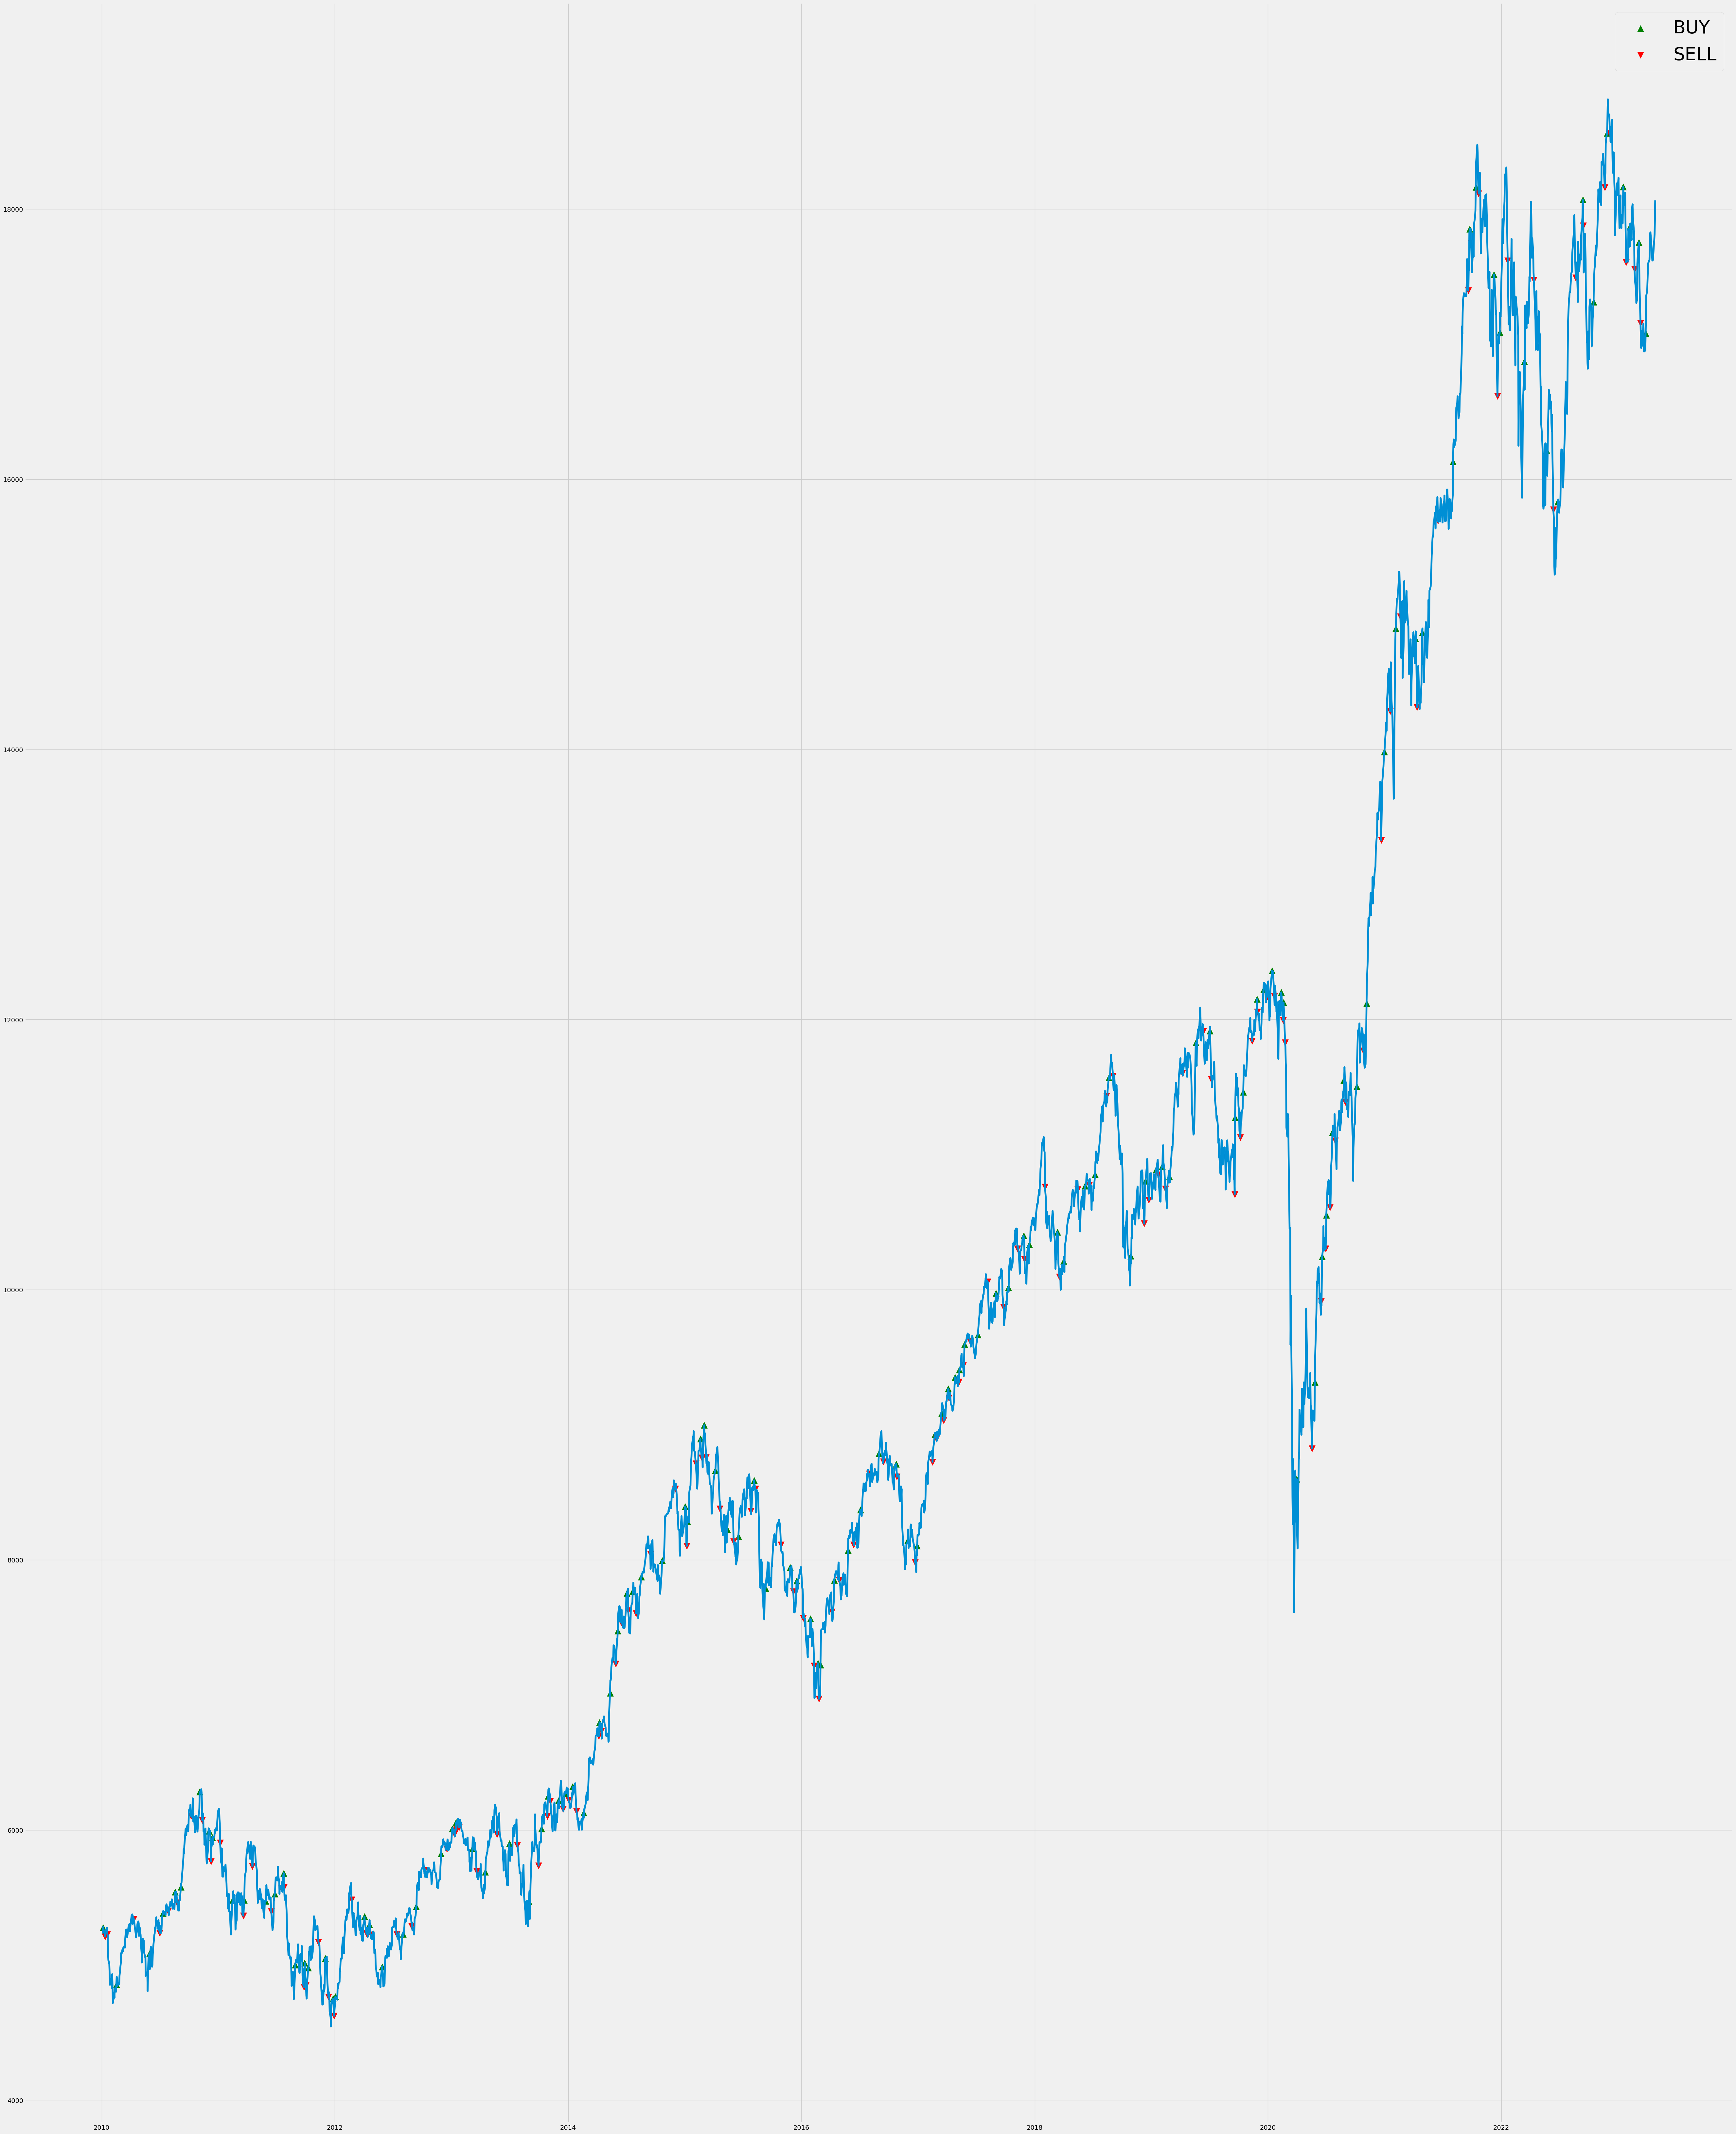

In [201]:
plt.figure(figsize=(60,80))
plt.plot( data['Close'])
plt.scatter(data.index, data.buy_sig, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(data.index, data.sell_sig, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.legend(fontsize="40")
plt.show()

In [202]:
np_buy_md=np_buy_md[:-1]
(np_sell_md-np_buy_md).mean()

60.898765625

In [203]:
def sharpe_ratio(data, risk_free_rate=0.035):
    
    mean_return = data.mean()
    
    sigma = data.std()
    return (mean_return/sigma)

def sortino_ratio(data):
    
    mean_return = data.mean()
    
    std_neg = data[data<0].std()
    return mean_return/std_neg


In [204]:
pd.DataFrame(np_buy_md-np_sell_md).idxmin()
print("MDD_MACD",(np_buy_md-np_sell_md).min()/np_sell_md[22,0]*100,"%")
print("CUMM_Return_MACD",((np_sell_md-np_buy_md)/np_buy_md).max()*100,"%")

MDD_MACD -31.758770836202398 %
CUMM_Return_MACD 15.06725766327907 %


In [205]:
sharpe_ratio(np_sell_md-np_buy_md), sortino_ratio(np_sell_md-np_buy_md)

(0.16675361734907584, 0.38904088624809824)

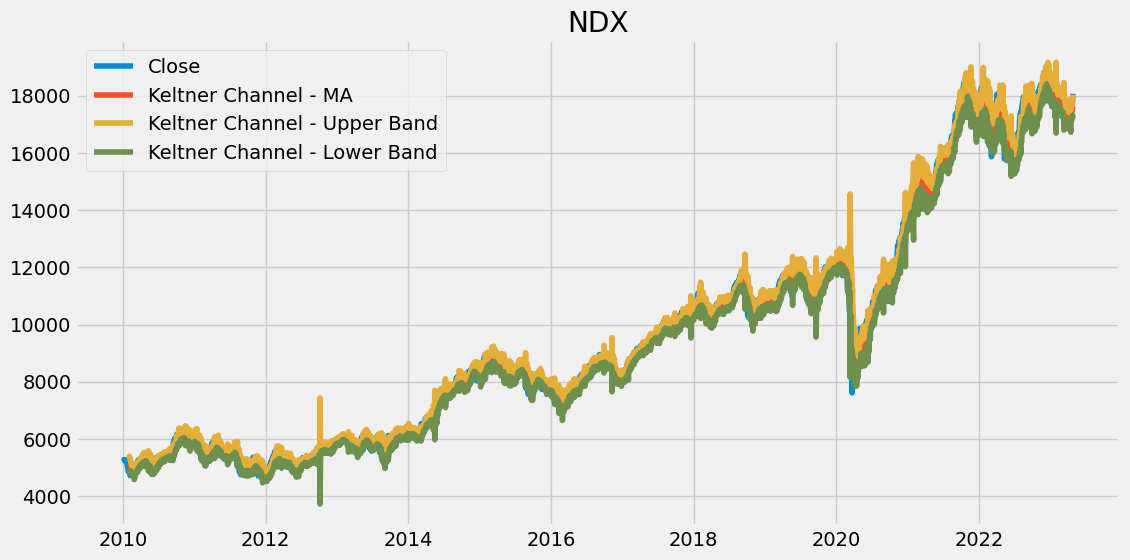

In [206]:
data=nsei
data['KC_MA'] = data['Close'].rolling(window=20).mean()
data['KC_ATR'] = data['High'] - data['Low']
data['KC_UB'] = data['KC_MA'] + (2 * data['KC_ATR'])
data['KC_LB'] = data['KC_MA'] - (2 * data['KC_ATR'])
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close')
plt.plot(data['KC_MA'], label='Keltner Channel - MA')
plt.plot(data['KC_UB'], label='Keltner Channel - Upper Band')
plt.plot(data['KC_LB'], label='Keltner Channel - Lower Band')
plt.title("NDX")
plt.legend()
plt.show()

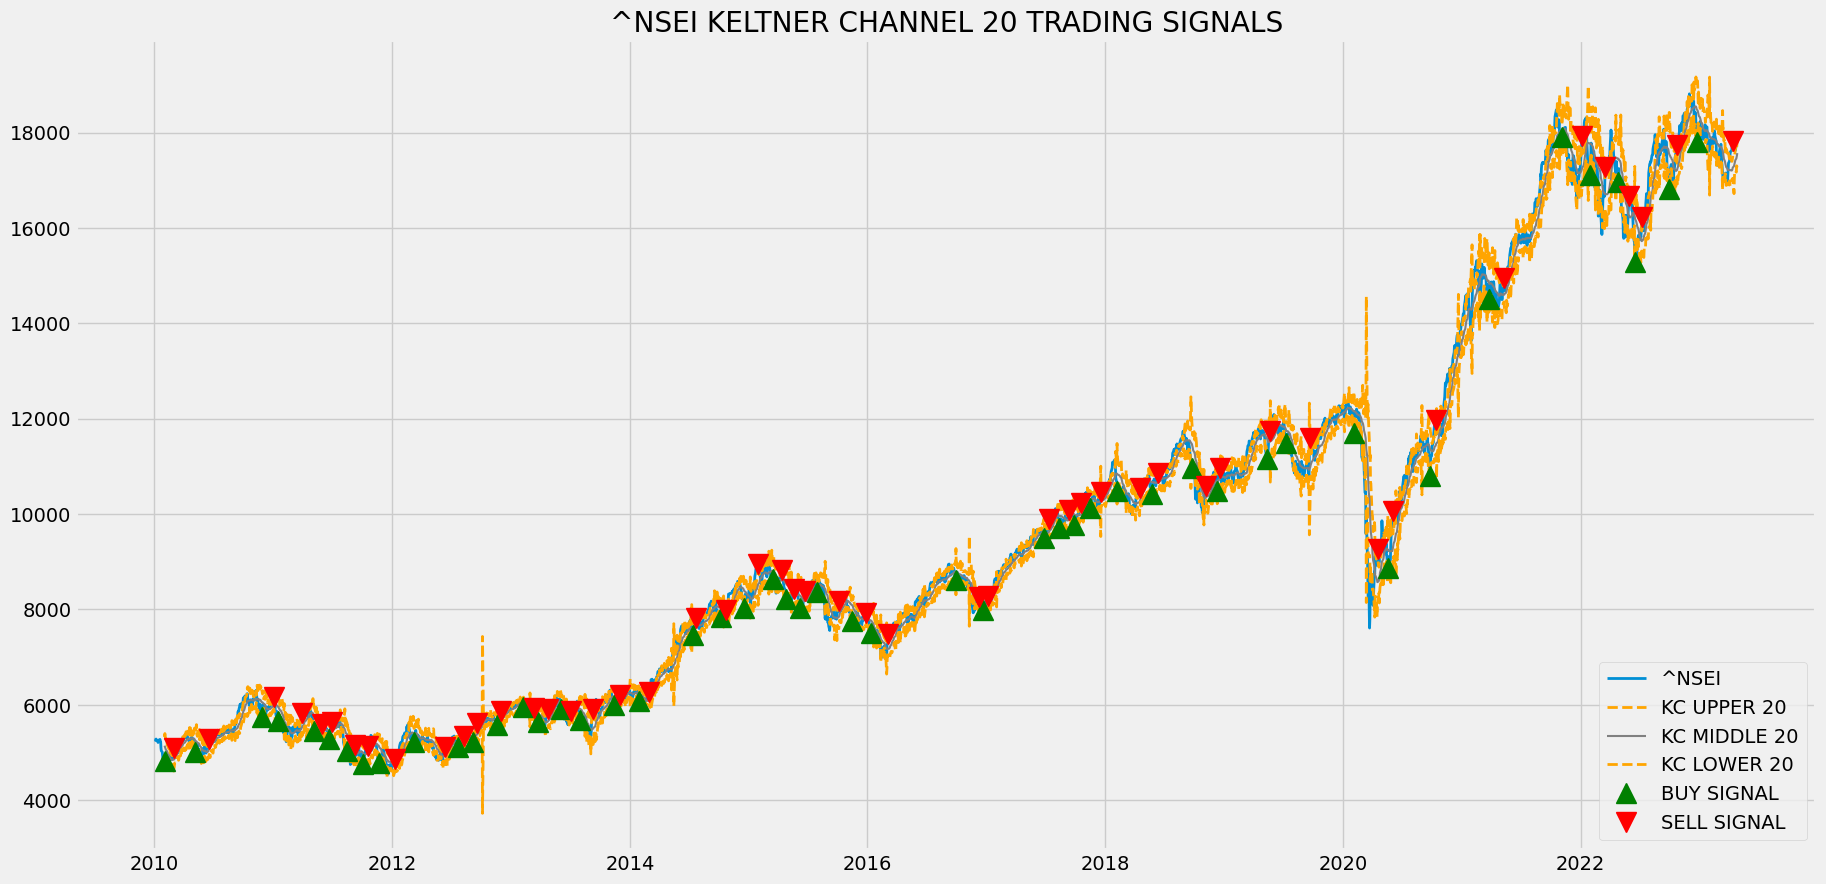

In [207]:
def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)-1):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal
buy_price, sell_price, kc_signal = implement_kc_strategy(data['Close'], data['KC_UB'], data['KC_LB'])
data=data.iloc[:-1,:]

plt.figure(figsize=(20,10))
plt.plot(data['Close'], linewidth = 2, label = '^NSEI')
plt.plot(data['KC_UB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(data['KC_MA'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(data['KC_LB'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
plt.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('^NSEI KELTNER CHANNEL 20 TRADING SIGNALS')
plt.show()

In [208]:
buy_kc=pd.DataFrame(buy_price)
buy_kc=buy_kc.fillna(0)
buy_kc=buy_kc[~(buy_kc == 0).all(axis=1)]
sell_kc=pd.DataFrame(sell_price)
sell_kc=sell_kc.fillna(0)
sell_kc=sell_kc[~(sell_kc == 0).all(axis=1)]
np1=np.array(buy_kc)
np2=np.array(sell_kc)
(np2-np1).mean()
(np2-np1).std()
buy_kelt=pd.DataFrame(buy_price)
sell_kelt=pd.DataFrame(sell_price)
buy_kelt=buy_kelt.fillna(0)
sell_kelt=sell_kelt.fillna(0)

In [209]:
def sharpe_ratio(data, risk_free_rate=0):
    # Calculate Average  Return
    mean_daily_return = data.mean()
    # Calculate Standard Deviation
    sigma = data.std()
    return (mean_daily_return/sigma)

In [210]:
def sortino_ratio(data):
    # Calculate Average  Return
    mean_return = data.mean()
    # Calculate Standard Deviation
    std_neg = data[data<0].std()
    return mean_return/std_neg

In [211]:
sharpe_ratio(np2-np1), sortino_ratio(np2-np1)

(0.43806388624799114, 0.30309615580830157)

In [212]:
print("MDD_KC",(np1-np2).min()/np2[18,0]*100,"%")
print("CUMM_Return_KC",((np2-np1)/np1).max()*100,"%")

MDD_KC -18.837973195892648 %
CUMM_Return_KC 13.317230883005408 %


In [213]:
from sklearn.model_selection import GridSearchCV
import ta
from sklearn.base import BaseEstimator

In [214]:
# Custom estimator class for Keltner Channel
class KeltnerChannelEstimator(BaseEstimator):
    def __init__(self, window):
        self.window = window

    def fit(self, X, y=None):
        indicator = ta.volatility.KeltnerChannel(X['Close'], X['Low'], X['Close'], window=self.window, fillna=True)
        return self

# Custom estimator class for Bollinger Bands
class BollingerBandsEstimator(BaseEstimator):
    def __init__(self, window):
        self.window = window

    def fit(self, X, y=None):
        indicator = ta.volatility.BollingerBands(X['Close'], window=self.window, fillna=True)
        return self
# Custom estimator class for MACD

class MACDEstimator(BaseEstimator):
    def __init__(self, window_slow, window_fast):
        self.window_slow = window_slow
        self.window_fast = window_fast

    def fit(self, X, y=None):
        indicator = ta.trend.MACD(X['Close'], window_slow=self.window_slow, window_fast=self.window_fast, fillna=True)
        return self


In [215]:

# Define the parameter grid for each indicator
keltner_params = {'window': [10, 20, 30]}
bollinger_params = {'window': [10, 20, 30]}
macd_params = {'window_slow': [26, 30, 34], 'window_fast': [12, 14, 16]}

# Define the scoring metrics for evaluation
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}

In [216]:
nas_df=nasdaq
nse_df=nsei

In [217]:
keltner_grid = GridSearchCV(estimator=KeltnerChannelEstimator(window=10), param_grid=keltner_params, scoring=scoring, refit=False)
keltner_grid.fit(nas_df)
keltner_results = pd.DataFrame(keltner_grid.cv_results_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _PredictScorer._score() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


In [218]:
bollinger_grid = GridSearchCV(estimator=BollingerBandsEstimator(window=10), param_grid=bollinger_params, scoring=scoring, refit=False)
bollinger_grid.fit(nas_df)
bollinger_results = pd.DataFrame(bollinger_grid.cv_results_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _PredictScorer._score() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


In [219]:
macd_estimator = MACDEstimator(window_slow=26, window_fast=12)

macd_grid = GridSearchCV(estimator=macd_estimator, param_grid=macd_params, scoring=scoring, refit=False)
macd_grid.fit(nas_df)
macd_results = pd.DataFrame(macd_grid.cv_results_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _PredictScorer._score() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [220]:
# Evaluate the grid search results
keltner_best_params = keltner_results.loc[keltner_results['rank_test_accuracy'] == 1, 'params'].values[0]
bollinger_best_params = bollinger_results.loc[bollinger_results['rank_test_accuracy'] == 1, 'params'].values[0]
macd_best_params = macd_results.loc[macd_results['rank_test_accuracy'] == 1, 'params'].values[0]

print("Optimized Parameters:")
print("Keltner Channel:", keltner_best_params)
print("Bollinger Bands:", bollinger_best_params)
print("MACD:", macd_best_params)

Optimized Parameters:
Keltner Channel: {'window': 10}
Bollinger Bands: {'window': 10}
MACD: {'window_fast': 12, 'window_slow': 26}


In [221]:

keltner_indicator = ta.volatility.KeltnerChannel(nas_df['Close'], nas_df['Low'], nas_df['Close'], window=keltner_best_params['window'], fillna=True)
bollinger_indicator = ta.volatility.BollingerBands(nas_df['Close'], window=bollinger_best_params['window'], fillna=True)
macd_indicator = ta.trend.MACD(nas_df['Close'], window_slow=macd_best_params['window_slow'], window_fast=macd_best_params['window_fast'], fillna=True)


keltner_signal = np.where(nas_df['Close'] > keltner_indicator.keltner_channel_hband(), 1, 0)  # Buy signal
bollinger_signal = np.where(nas_df['Close'] < bollinger_indicator.bollinger_lband(), -1, 0)  # Sell signal
macd_signal = np.where(macd_indicator.macd() > macd_indicator.macd_signal(), 1, -1)  # Buy and sell signals based on MACD histogram



combined_signal = keltner_signal + bollinger_signal + macd_signal

signals = pd.DataFrame({
    'Signal': combined_signal
})

signals['Return'] = signals['Signal'].shift(-1) * nas_df['Close'].pct_change()

total_trades = len(signals)
positive_trades = len(signals[signals['Return'] > 0])
negative_trades = len(signals[signals['Return'] < 0])
win_rate = positive_trades / total_trades * 100

print("Generated Signals:")
print(signals)

print("\nMetrics:")
print("Total Trades:", total_trades)
print("Positive Trades:", positive_trades)
print("Negative Trades:", negative_trades)
print("Win Rate (%):", win_rate)


Generated Signals:
      Signal  Return
0         -1     NaN
1          1     NaN
2         -1     NaN
3         -1     NaN
4          2     NaN
...      ...     ...
3348      -1     NaN
3349      -2     NaN
3350      -1     NaN
3351       0     NaN
3352       0     NaN

[3353 rows x 2 columns]

Metrics:
Total Trades: 3353
Positive Trades: 0
Negative Trades: 0
Win Rate (%): 0.0
